In [ ]:
def createPrintedLine(iden,
                       comps,
                       font_path,
                       font_size):
    '''
        creates printed word image
        args:
            iden    :       identifier marking value starting
            comps   :       the list of components
            font_path:      the desired font path 
            font_size:      the size of the font
        returns:
            img     :       marked word image
            label   :       dictionary of label {iden:label}
            iden    :       the final identifier
    '''
    val_offset=iden
    comps=[str(comp) for comp in comps]
    # max dim
    min_offset=100
    max_dim=len(comps)*font_size+min_offset
    # reconfigure comps
    mods=['ঁ', 'ং', 'ঃ']
    for idx,comp in enumerate(comps):
        if idx < len(comps)-1 and comps[idx+1] in mods:
            comps[idx]+=comps[idx+1]
            comps[idx+1]=None 
            
    comps=[comp for comp in comps if comp is not None]
    word="".join(comps)
    # font path
    font=ImageFont.truetype(font_path, size=font_size)
    # sizes of comps
    (comp_size,_),(_,_) = font.font.getsize(word)  
    # construct labels
    label={}
    imgs=[]
    x=0
    y=0
    comp_str=''
    for comp in comps:
        comp_str+=comp
        # # calculate increment
        # (comp_width,_),(offset,_)=comp_size
        # dx = comp_width+offset 
        # draw
        image = Image.new(mode='L', size=(max_dim,max_dim))
        draw = ImageDraw.Draw(image)
        #draw.text(xy=(x, y), text=comp, fill=iden, font=font)
        draw.text(xy=(0, 0), text=comp_str, fill=1, font=font)
        
        imgs.append(np.array(image))
        
        # x+=dx
        # label
        label[iden] = comp 
        iden+=1
        
        
    # add images
    img=sum(imgs)
    #img=stripPads(img,0)
    img=img[~np.all(img == 0, axis=1)]
    img=img[:,:comp_size]
    img[img>0]+=val_offset-1
    return img,label,iden


def padImg(line_img,h_max,w_max): ### <<<<<=================
    # shape
    h,w=line_img.shape
    # pad widths
    left_pad_width =(w_max-w)//2
    # print(left_pad_width)
    right_pad_width=w_max-w-left_pad_width
    # pads
    left_pad =np.zeros((h,left_pad_width))
    right_pad=np.zeros((h,right_pad_width))
    # pad
    line_img =np.concatenate([left_pad,line_img,right_pad],axis=1)
    
    # shape
    h,w=line_img.shape
    # pad heights
    top_pad_height =(h_max-h)//2
    bot_pad_height=h_max-h-top_pad_height
    # pads
    top_pad =np.zeros((top_pad_height,w))
    bot_pad=np.zeros((bot_pad_height,w))
    # pad
    line_img =np.concatenate([top_pad,line_img,bot_pad],axis=0)
    return line_img

In [ ]:
def selectPrintTextRegions(mask, 
                           cell_widths): 
    '''
          @function author:
          
          select the regions for placing text on mask images.

          args:
              mask        =   table image which contains raws and columns  
              
              cell_widths =   the width of a single cell                          : type <LIST>                   
                              * for each column a width must be provided 
              
          returns:
              slt_serial  =    select label regions of SL raws : type <LIST>
              slt_brand   =    select label regions of Brand raws : type <LIST>
              slt_total   =    select label regions of Total : type <int>  
              slt_others  =    select label regions of other columns name i.e., Quality, Rate, Taka : type <LIST>
              final_list  =    merge of all lists (slt_serial + slt_brand + [slt_total] + slt_others) : type <LIST>
              label_img   =    an integer 'ndarray' where each unique feature in input has a unique label in the returned array.
          
          tools:
              * cv2
              * scipy.ndimage.measurements.label
              https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.measurements.label.html
              
      '''

    '''
        label_img  =  An integer 'ndarray' where each unique feature in input has a unique label in the returned array.
        num_areas  =  'int', then it will be updated with values in labeled_array and only num_features will be returned by this function.
    '''
    label_img,num_areas = sni.measurements.label(mask)
    # unique value (array) of label_img
    lst = np.unique(label_img)[1:num_areas]
    # length of 'cell_widths' param
    len_cell_widths=len(cell_widths)
    
    # store unique value for Sl columns
    slt_serial = []
    for val in lst:
      if val%len_cell_widths == 1:
        slt_serial.append(val)
    slt_serial = slt_serial[:-1]

    # store unique value for Brand columns
    slt_brand = []
    for val in lst:
      if val%len_cell_widths == 2:
        slt_brand.append(val)
    slt_brand = slt_brand[:-1]

    # store unique value Total box
    slt_total = lst[len(lst)-2]

    # store unique value for other columns
    slt_others = list(range(3,len_cell_widths+1))

    # merge of all lists
    final_list = slt_serial + slt_brand + slt_others + [slt_total]


    return slt_serial, slt_brand, slt_total, slt_others, final_list,label_img

## Draw Print Text on Table

In [ ]:
def drawsPrintTextOnTable(printTextData,
                          total,
                          class_map_csv_path,
                          font_path,
                          font_size=128,
                          bangla_num=["০","১","২","৩","৪","৫","৬","৭","৮","৯"],
                          iden=3,
                          h_max=160,
                          line_width=2
                          ):

    """
          @function author:
          
          Place Print Bangla text on specific loactions of Binary Image.

          args:
              printTextData   =    format of example dictionary: dict_ = {'serial': ["সেরিঃ",  
                                                                                    "১",
                                                                                    "২",
                                                                                    "৩", 
                                                                                    "৪", 
                                                                                    "৫" ],
                                                                        'brand': ["ব্র্যান্ডের নাম", 
                                                                                    "র‍্যান্ডম প্রোডাক্ট নাম্বার ১",      : type <DICT>
                                                                                    "র‍্যান্ডম বিড়ি",
                                                                                    "আরো কিছু",
                                                                                    "৪২০ মার্কা বিড়ি",
                                                                                    "রং নাম্বার"],
                                                                        'quantity': ["কোয়ান্টিটি"],
                                                                        'rate': ["রেইট/গ্রোস"], 
                                                                        'taka': ["টাকা"]
                                                                        
                                                                      } 
                                    keys of the dictioary mention columns's name ("সেরিঃ","ব্র্যান্ডের নাম", "কোয়ান্টিটি", "রেইট/গ্রোস", "টাকা").
                                    Others are serials and products name. 

              total               =  text of total box (N.B., you can insert no value (None)). (example:total = ["টোটাল"])  : type <LIST>  

              class_map_csv_path  =  path of "classes.csv"  <'./class_map.csv'>    
              
              font_path           =  the desired font path. <'/Bangla.ttf'> 
              
          returns:
              TableImg            =  Binary Image after placing text on desired locations.

    """

    gp=GraphemeParser(class_map_csv_path)           ######## <<<=============== Call GraphemeParser Class

    ## Create Function: for Process the Text data
    def processText(dataText,
                    gp=gp,
                    bangla_num=bangla_num
                    ):
        data=[]
        for p in dataText:
          words=p.split()
          _data=[]
          # add space after a word
          for word in words:
            if any(char in bangla_num for char in word):
              graphemes=[g for g in word]
            else:
              graphemes=gp.word2grapheme(word)
            graphemes.append(" ")
            _data+=graphemes
          data.append(_data)
        return data

    ## Create Function: find images and labels
    def imgsLabels(processTextData,
                   iden=iden,
                   font_path=font_path,
                   font_size=font_size,
                   h_max=h_max
                   ):
        imgs=[]
        labels=[]
        w_max=0

        # find images and labels
        for line in processTextData:                     
          img,label,iden=createPrintedLine(iden,
                                          line,
                                          font_path,             ######## <<<=============== Call Function
                                          font_size)
          h,w=img.shape
          if w>w_max:
            w_max=w

          imgs.append(img)
          labels.append(label)


        w_max+=32
        padded=[]
        for img in imgs:
          img=padImg(img,h_max,w_max) ### <<<<<================= Call Function
          padded.append(img)

        return imgs, labels, padded, w_max

    ### ===== Process printTextData =========== ###
    printTextDataProcess = {}

    ### Process Sl, Brand, Quantity, Rate, Taka Columns
    for key, data_text in printTextData.items():
      data = processText(data_text)                        ######## <<<=============== Call Function
      imgs, labels, padded, w_max = imgsLabels(data)       ######## <<<=============== Call Function
      printTextDataProcess[key] = [imgs, labels, padded, w_max]

    #### =Process Total box  ==== 
    if total:
      data_total=processText(total)                ######## <<<=============== Call Function
      _w_max = list(printTextDataProcess.keys())[-2]
      w_max_total = printTextDataProcess[_w_max][3]
      imgs_total = []
      labels_total = []
      for line in data_total:
         img,label,iden=createPrintedLine(iden,
                                          line,
                                          font_path,             ######## <<<=============== Call Function
                                          font_size)
         imgs_total.append(img)
         labels_total.append(label)         

      padded_total=[]
      for img in imgs_total:
        img=padImg(img,h_max,w_max_total) ### <<<<<================= Function
        padded_total.append(img)
        # plt.imshow(padImg(img,h_max,w_max_total))
        # plt.show()

      printTextDataProcess['total'] = [imgs_total, labels_total, padded_total, w_max_total]

    ## ==== Create Table =========
    _serial_key = list(printTextData.keys())[0]
    num_rows = len(printTextData[_serial_key])+2
    num_columns = len(printTextData)+1 #6/5/7
    cell_height = h_max+line_width
    cell_widths = []
    for key, data_text in printTextData.items():
      w_max = printTextDataProcess[key][3]
      cell_width = w_max + line_width
      cell_widths.append(cell_width)

    ## Create Table
    TableImg=createTable( num_rows,    
                      num_columns, 
                      line_width,  
                      cell_widths,  
                      cell_height)


    ## merge all padded
    padded_all = []
    for key, data_text in printTextDataProcess.items():
      # print(key)
      pad = printTextDataProcess[key][2]
      for k in pad:
        padded_all.append(k)
        # plt.imshow(k)
        # plt.show()

    ## select locations for placing text
    serial_locs,brand_locs,total_loc,other_locs,all_locs,labeled_img=selectPrintTextRegions(TableImg, cell_widths)

    ## Binary Image: TableImg
    TableImg=255-TableImg
    TableImg[TableImg>0]=1

    ## Place text on specific location of TableImg
    for locs, pads in zip(all_locs, padded_all):
      for i,img in zip([locs],[pads]):
        idx = np.where(labeled_img==i)
        y_min,y_max,x_min,x_max = np.min(idx[0]), np.max(idx[0]), np.min(idx[1]), np.max(idx[1])
        TableImg[y_min:y_max,x_min:x_max]=img

        # plt.imshow(TableImg)
        # plt.show() 

    return TableImg


### Pass Parameters to the function

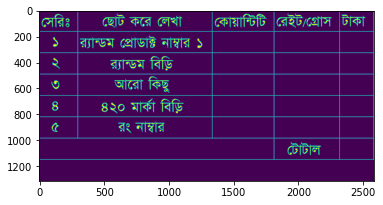

In [ ]:

printTextData = {'serial': ["সেরিঃ",  
                            "১",
                            "২",
                            "৩", 
                            "৪", 
                            "৫" ],
                 'brand': ["ছোট করে লেখা", 
                            "র‍্যান্ডম প্রোডাক্ট নাম্বার ১",
                            "র‍্যান্ডম বিড়ি",
                            "আরো কিছু",
                            "৪২০ মার্কা বিড়ি",
                            "রং নাম্বার"],
                 'quantity': ["কোয়ান্টিটি"],
                 'rate': ["রেইট/গ্রোস"], 
                 'taka': ["টাকা"]
                 
              }

total = ["টোটাল"]


Table_Image_with_Text = drawsPrintTextOnTable(printTextData, total, class_map_csv, font_path)

TableImg = Table_Image_with_Text
TableImg[TableImg>0]=255
plt.imshow(TableImg)
plt.show()

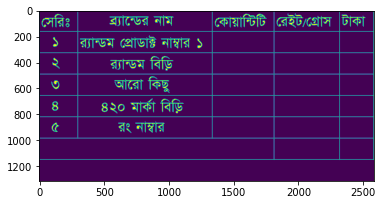

In [ ]:

printTextData = {'serial': ["সেরিঃ",  
                            "১",
                            "২",
                            "৩", 
                            "৪", 
                            "৫" ],
                 'brand': ["ব্র্যান্ডের নাম", 
                            "র‍্যান্ডম প্রোডাক্ট নাম্বার ১",
                            "র‍্যান্ডম বিড়ি",
                            "আরো কিছু",
                            "৪২০ মার্কা বিড়ি",
                            "রং নাম্বার"],
                 'quantity': ["কোয়ান্টিটি"],
                 'rate': ["রেইট/গ্রোস"], 
                 'taka': ["টাকা"]
                 
              }

total = None


Table_Image_with_Text = drawsPrintTextOnTable(printTextData, total, class_map_csv, font_path)

TableImg = Table_Image_with_Text
TableImg[TableImg>0]=255
plt.imshow(TableImg)
plt.show()

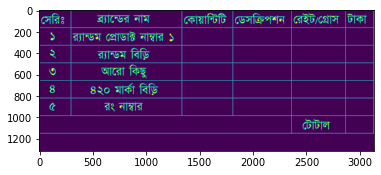

In [ ]:

printTextData = {'serial': ["সেরিঃ",  
                            "১",
                            "২",
                            "৩", 
                            "৪", 
                            "৫" ],
                 'brand': ["ব্র্যান্ডের নাম", 
                            "র‍্যান্ডম প্রোডাক্ট নাম্বার ১",
                            "র‍্যান্ডম বিড়ি",
                            "আরো কিছু",
                            "৪২০ মার্কা বিড়ি",
                            "রং নাম্বার"],
                 'quantity': ["কোয়ান্টিটি"],
                 'description': ["ডেসক্রিপশন"], 
                 'rate': ["রেইট/গ্রোস"], 
                 'taka': ["টাকা"]
                 
              }

total = ["টোটাল"]


Table_Image_with_Text = drawsPrintTextOnTable(printTextData, total, class_map_csv, font_path)

TableImg = Table_Image_with_Text
TableImg[TableImg>0]=255
plt.imshow(TableImg)
plt.show()

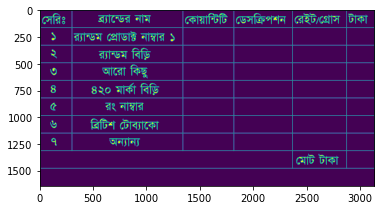

In [ ]:

printTextData = {'serial': ["সেরিঃ",  
                            "১",
                            "২",
                            "৩", 
                            "৪", 
                            "৫",
                            "৬",
                            "৭"],
                 'brand': ["ব্র্যান্ডের নাম", 
                            "র‍্যান্ডম প্রোডাক্ট নাম্বার ১",
                            "র‍্যান্ডম বিড়ি",
                            "আরো কিছু",
                            "৪২০ মার্কা বিড়ি",
                            "রং নাম্বার",
                            "ব্রিটিশ টোব্যাকো",
                            "অন্যান্য"],
                 'quantity': ["কোয়ান্টিটি"],
                 'description': ["ডেসক্রিপশন"], 
                 'rate': ["রেইট/গ্রোস"], 
                 'taka': ["টাকা"]
                 
              }

total = ["মোট টাকা"]


Table_Image_with_Text = drawsPrintTextOnTable(printTextData, total, class_map_csv, font_path)

TableImg = Table_Image_with_Text
TableImg[TableImg>0]=255
plt.imshow(TableImg)
plt.show()

## End